In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [30]:
#CROPP CODE FOR IMAGE TRAINING
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
%matplotlib inline
import tensorflow as tf
#np.set_printoptions(threshold=np.inf)
from tensorflow import estimator
tf.reset_default_graph()
from sklearn.model_selection import train_test_split
gs = 0
N_CLASSES = 4   
IMG_W = 200      # for better visibility, go with >180
IMG_H = 200
learning_rate = 0.0001     #slow learning rate for better learning
MODEL = './DNN_Model'
NUM_EPOCH = 50
BATCH_SIZE = 16
LOOP = 16                # total no. of epoch = loop * 2*num_epoch
disease ={0:'Healthy', 
          1:'Mosaic_Virus', 
          2:'rust', 
          3:'woolyaphids'}       
def normalize(df):    
    return (df - df.min()) / (df.max() - df.min())
def denormalize(df,norm_data):    
    return (norm_data * (df.max() - df.min())) + df.min()

In [31]:
def getdata(path):
    ''' returns shuffled array of image file path and labels of corresponding file '''
    woolyaphids = []
    woolyaphids_l= []
    Healthy = []
    Healthy_l = []
    Mosaic_Virus = []
    Mosaic_Virus_l = []
    rust = []
    rust_l = []
    for file in os.listdir(path):
        name=file.split(sep='.')
        if 'healthy' in name[0]:
            Healthy.append(path+file)
            Healthy_l.append(0)
        elif 'Mosaic_Virus' in name[0]:
            Mosaic_Virus.append(path+file)
            Mosaic_Virus_l.append(1)
        elif 'mosaic_virus' in name[0]:
            Mosaic_Virus.append(path+file)
            Mosaic_Virus_l.append(1)
        elif 'rust' in name[0]:
            rust.append(path+file)
            rust_l.append(2)
        elif 'Woolyaphids' in name[0]:
            woolyaphids.append(path+file)
            woolyaphids_l.append(3)
        elif 'woolyaphids' in name[0]:
            woolyaphids.append(path+file)
            woolyaphids_l.append(3)
            
    image_list = np.hstack((Healthy, Mosaic_Virus, rust, woolyaphids ))
    label_list = np.hstack(( Healthy_l, Mosaic_Virus_l, rust_l, woolyaphids_l))
    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    #shuffle whole files and labels respectively
    np.random.shuffle(temp)
    image_list = list(temp[:, 0])
    label_list = list(temp[:, 1])
    label_list = [int(i) for i in label_list]
    print("Healthy plant is: ", len(Healthy))
    print("Rust disease plant is: ", len(rust))
    print("Mosaic_Virus plant is: ", len(Mosaic_Virus))
    print("Woolyaphids plant is: ", len(Mosaic_Virus))
    return image_list, label_list

def process(path):
    '''this function takes file paths from getdata function, 
it reads and processes image file in 4D tensor format i.e.
[batch_size, IMG_Width, IMG_Height, channel]   for grayscale channel = 1, for RGB, channel = 3
'''
    a, train_labels = getdata(path)
    img = []
    batch=len(a)
    for i in range(batch):
        im = cv2.imread(a[i], cv2.IMREAD_COLOR) 
        b,g,r = cv2.split(im)
        image = cv2.merge([r,g,b])
        res = cv2.resize(image,(IMG_W, IMG_H), interpolation = cv2.INTER_CUBIC)
        img.append(res)
        if i%50 == 0: print('Processed {} of {}'.format(i, batch))
    print("finished\nCount of Images is ",len(img),"with input shape",res.shape)
    return np.array(img, dtype=np.int32), np.array(train_labels[:batch], dtype = np.int32)


In [32]:
import os
path = os.path.abspath("DNN_New_Data")
path = path+'\\'
# path
X, Y = process(path)

Healthy plant is:  155
Rust disease plant is:  136
Mosaic_Virus plant is:  151
Woolyaphids plant is:  151
Processed 0 of 592
Processed 50 of 592
Processed 100 of 592
Processed 150 of 592
Processed 200 of 592
Processed 250 of 592
Processed 300 of 592
Processed 350 of 592
Processed 400 of 592
Processed 450 of 592
Processed 500 of 592
Processed 550 of 592
finished
Count of Images is  592 with input shape (200, 200, 3)


In [33]:
data = []
for i in X:
    data.append(i.reshape(IMG_W*IMG_H*3))
data = np.array(data)

In [34]:
print('shape of whole data and their labels are as follows',data.shape,'and',Y.shape,"respectively")

shape of whole data and their labels are as follows (592, 120000) and (592,) respectively


actually it is: rust


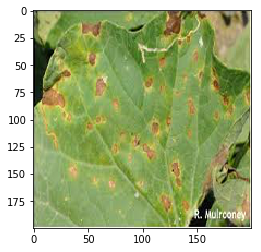

actually it is: woolyaphids


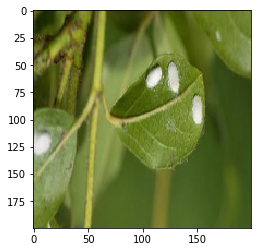

actually it is: woolyaphids


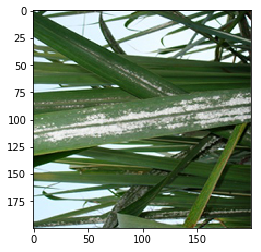

actually it is: Healthy


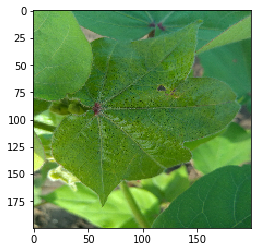

actually it is: woolyaphids


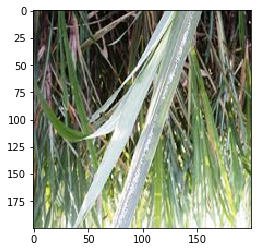

actually it is: rust


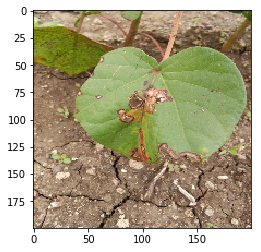

actually it is: woolyaphids


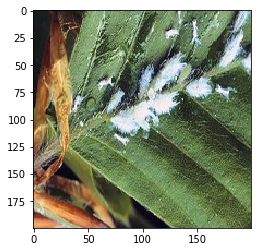

actually it is: woolyaphids


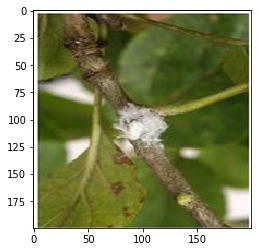

actually it is: Healthy


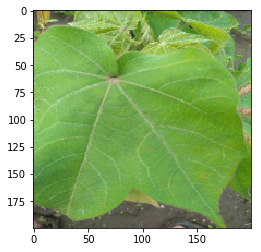

actually it is: Mosaic_Virus


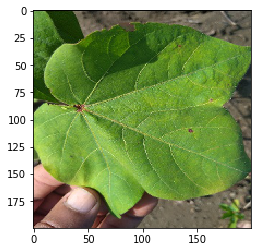

In [35]:
for i in range(170, 180):
    j =data[i].reshape(IMG_W,IMG_H,3)
    print("actually it is:",disease[Y[i]])
    plt.imshow(j)
    plt.show()  
#this cell is used to ensure proper labelling of image

In [36]:
X_train, X_val, Y_train, Y_val = train_test_split(data ,Y, test_size=0.3, random_state=1)

In [37]:
X_tr = []
for i in X_train:
    X_tr.append(normalize(i))
X_tr = np.array(X_tr)

X_v = []
for i in X_val:
    X_v.append(normalize(i))
X_v = np.array(X_v)

In [38]:
feat_cols=[tf.feature_column.numeric_column('x', shape=[IMG_H*IMG_W*3])]

In [40]:
deep_model = tf.estimator.DNNClassifier(feature_columns=feat_cols, 
                                      n_classes=N_CLASSES,
                                      hidden_units=[100, 100, 100, 100, 100,50], 
                                      activation_fn=tf.nn.leaky_relu,
                                      optimizer=tf.train.GradientDescentOptimizer(learning_rate),
                                      model_dir=MODEL)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './DNN_Model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020E0C96C080>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [41]:
input_fn = estimator.inputs.numpy_input_fn(x={'x':np.array(X_tr)}, 
                                           y=np.array(Y_train),
                                           shuffle= True,
                                           num_epochs=NUM_EPOCH,
                                           batch_size=BATCH_SIZE)

In [42]:
input_fn_eval = estimator.inputs.numpy_input_fn(x = {'x':np.array(X_v)},
                                                y = Y_val,
                                                shuffle=False)

In [43]:
for i in range(LOOP):
    gs = gs + NUM_EPOCH*2
    train_spec = tf.estimator.TrainSpec(input_fn = input_fn, max_steps = gs)
    eval_spec  = tf.estimator.EvalSpec(input_fn = input_fn_eval)
    tf.estimator.train_and_evaluate(deep_model, train_spec, eval_spec)
    
    print("*************************************************************************************** step = ", i)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ./DNN_Model\model.ckpt.
INFO:tensorflow:loss = 22.074411, step = 1
INFO:tensorflow:Saving checkpoints for 100 into ./DNN_Model\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-31-14:32:08
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./DNN_Model\model.ckpt-100
INFO:tensorflow:Running local_init_op.
INFO:te

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 500 into ./DNN_Model\model.ckpt.
INFO:tensorflow:loss = 8.244147, step = 501
INFO:tensorflow:Saving checkpoints for 600 into ./DNN_Model\model.ckpt.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-10-31-14:33:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./DNN_Model\model.ckpt-600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-31-14:33:19
INFO:tensorflow:Saving dict for global step 600: accuracy = 0.83707863, average_loss = 0.49616456, global_step = 600, loss = 44.158646
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 600: ./DNN_Model\model.ckpt-600
INFO:tensorflow:Loss for final step: 1.737167.
*************************************************************************************** step =  5
INFO:tensor

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-10-31-14:34:28
INFO:tensorflow:Saving dict for global step 1100: accuracy = 0.85955054, average_loss = 0.44759896, global_step = 1100, loss = 39.836308
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1100: ./DNN_Model\model.ckpt-1100
INFO:tensorflow:Loss for final step: 0.74268025.
*************************************************************************************** step =  10
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring 

*************************************************************************************** step =  15


In [44]:
input_fn_eval = estimator.inputs.numpy_input_fn( x = {'x':X_v},
                                                shuffle = False)

preds=deep_model.predict(input_fn=input_fn_eval)

In [45]:
predictions = [p['class_ids'][0] for p in preds]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./DNN_Model\model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [46]:
pred = np.asarray(predictions)

prediction is: rust 
actually it is: rust


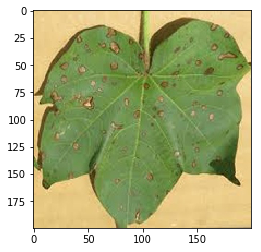

prediction is: woolyaphids 
actually it is: woolyaphids


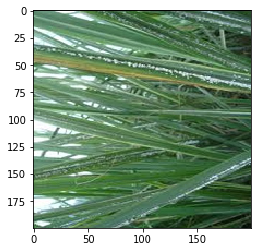

prediction is: Healthy 
actually it is: Healthy


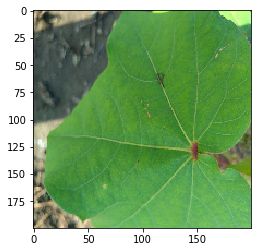

prediction is: rust 
actually it is: rust


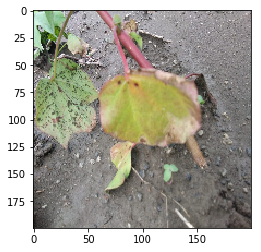

prediction is: Mosaic_Virus 
actually it is: Mosaic_Virus


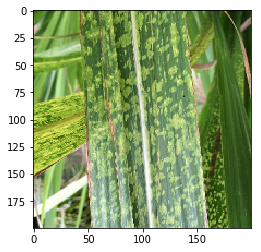

prediction is: Mosaic_Virus 
actually it is: Mosaic_Virus


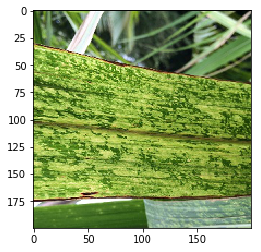

prediction is: Healthy 
actually it is: Healthy


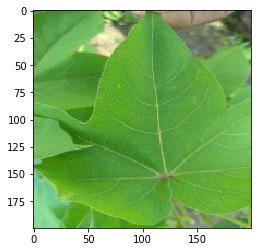

prediction is: Healthy 
actually it is: Healthy


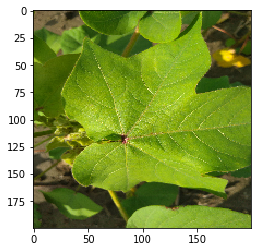

prediction is: rust 
actually it is: rust


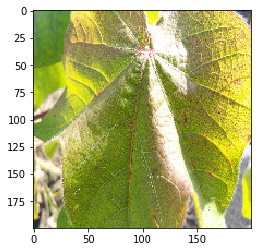

prediction is: rust 
actually it is: rust


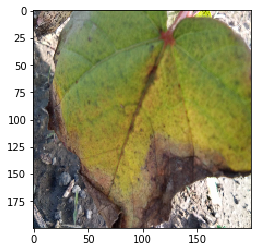

In [47]:
for i in range(17,27):
    j = X_v[i].reshape(IMG_W,IMG_H,3)
    print("prediction is:", disease[pred[i]],"\nactually it is:",disease[Y_val[i]])
    plt.imshow(j)
    plt.show()   


In [48]:
f = pred == Y_val
print(len(f))
T = len(f[f == True])
F = len(f[f == False])
print(T, F, T+F)
error = F/(T+F) * 100
print(error)

178
156 22 178
12.359550561797752


In [27]:
saver = tf.train.Saver()

ValueError: No variables to save